Transfer Learning with Pytorch: Classifying images based on the scene present- building, forest, mountain, glacier, sea, street using ~25k images from a kaggle dataset.

In [1]:

import torch
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Normalize
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data import DataLoader

# Step 1: Choose a Pre-Trained Model
import torchvision.models as models

# Load the pre-trained ResNet-50 model
p_model = models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 69.0MB/s]


Modify the previosuly trained resnet50 model. We change the number of classes to fit out input data and we create a single layer feed forward network for our final layer to fit 6 classes.

In [2]:
class ModifiedResNet(nn.Module):
    def __init__(self):
        super(ModifiedResNet, self).__init__()
        self.resnet = torch.hub.load('pytorch/vision', 'resnet50', pretrained=True)
        num_classes = 6
        self.resnet.fc = nn.Linear(p_model.fc.in_features, num_classes)  # Change the final fully connected layer for 6 classes

    def forward(self, x):
        return self.resnet(x)

model = ModifiedResNet()



Downloading: "https://github.com/pytorch/vision/zipball/main" to /root/.cache/torch/hub/main.zip


Here, we freeze pre trained layers.

In [3]:
for param in model.parameters():
    param.requires_grad = False

Here, we augment data to increase variability. We rotate, crop and then use the image as a pytorch tensor.

In [4]:
from torchvision.transforms.functional import pad

transform_train = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.Grayscale(num_output_channels=3),  # Convert to RGB format
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize as before
])

transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to RGB format
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

This is the path of the data.

In [5]:
path = '/kaggle/input/scene-classification'

In [6]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive


In [7]:
!unzip /content/drive/MyDrive/archive-2.zip

Streaming output truncated to the last 5000 lines.
  inflating: archive-2/train-scene classification/train/3198.jpg  
  inflating: __MACOSX/archive-2/train-scene classification/train/._3198.jpg  
  inflating: archive-2/train-scene classification/train/2286.jpg  
  inflating: __MACOSX/archive-2/train-scene classification/train/._2286.jpg  
  inflating: archive-2/train-scene classification/train/20602.jpg  
  inflating: __MACOSX/archive-2/train-scene classification/train/._20602.jpg  
  inflating: archive-2/train-scene classification/train/15861.jpg  
  inflating: __MACOSX/archive-2/train-scene classification/train/._15861.jpg  
  inflating: archive-2/train-scene classification/train/22015.jpg  
  inflating: __MACOSX/archive-2/train-scene classification/train/._22015.jpg  
  inflating: archive-2/train-scene classification/train/1957.jpg  
  inflating: __MACOSX/archive-2/train-scene classification/train/._1957.jpg  
  inflating: archive-2/train-scene classification/train/15875.jpg  
  inf

The csv file containing information about the data is read. The csv has images and their corresponding labels.

In [8]:

import pandas as pd
scenes_data = pd.read_csv('/content/archive-2/train-scene classification/train.csv')
images_data = scenes_data['image_name'][:]
labels_data = scenes_data['label'][:]

In [9]:
print(type(images_data))
scenes_data.info()

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17034 entries, 0 to 17033
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  17034 non-null  object
 1   label       17034 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 266.3+ KB


In [10]:
import numpy as np
print(f'Images data shape: {images_data.shape}')
print(f'Labels data shape: {labels_data.shape}')
print(f'Images data min: {np.min(images_data)}, max: {np.max(images_data)}')
print(f'Images data type: {images_data.dtype}')
print(f'Labels data type: {labels_data.dtype}')
print(f'Unique labels: {np.unique(labels_data)}')
print(f'Number of unique labels: {len(np.unique(labels_data))}')

Images data shape: (17034,)
Labels data shape: (17034,)
Images data min: 0.jpg, max: 9999.jpg
Images data type: object
Labels data type: int64
Unique labels: [0 1 2 3 4 5]
Number of unique labels: 6


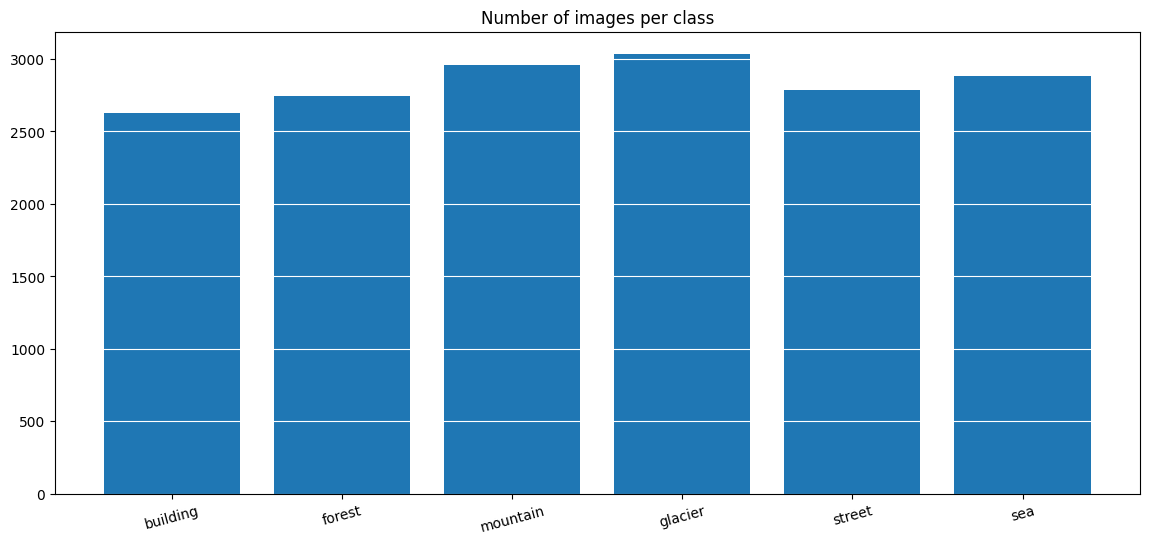

In [11]:
scene_names = [
 'building','forest','mountain','glacier','street',
    'sea'
]
unique, counts = np.unique(labels_data, return_counts=True)
ticks = np.arange(len(counts))
plt.figure(figsize=(14,6))
plt.grid(color='w', axis='y')
plt.bar(ticks, counts)
plt.xticks(ticks, scene_names, rotation=15)
plt.title('Number of images per class')
plt.show()

Here, we use slicing in numpy and to get our images and labels data. We then use matplotlib to plot the number of input images per class. As seen above, the number of images per class is of similar order.

The path after importing and downloading the kaggle dataset into the current workspace.

In [12]:
path="/content/archive-2/train-scene classification"

In [13]:
import os
os.listdir(path)

['train', '.DS_Store', 'train.csv']

Here, we apply the passed transforms on the passed dataset and return the image and its corresponding label.

In [14]:
from torchvision import datasets, transforms, models
from torch import nn, optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
class arrange_data(Dataset):
    """Dataset connecting animal images to the score and annotations"""

    def __init__(self, csv_file, img_dir, transform=transforms.ToTensor()):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        self.annotations_csv = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.image_files = self.annotations_csv['image_name'].tolist()

    def __len__(self):
        return len(self.annotations_csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.img_dir,
                                self.annotations_csv.iloc[idx, 0])
        # load each image in PIL format for compatibility with transforms
        image = PIL.Image.open(img_name)

        # Column 1 contains the label
        label = np.array(self.annotations_csv.iloc[idx, 1])
        # Apply the transforms
        image = self.transform(image)
        sample = [image, label]
        return sample



Here, we perform transforms on the train and validation data by resizing, cropping and rotating and flipping randomly selected images. The images are also converted into pytorch tensors.

In [15]:
img_transforms = transforms.Compose([transforms.Resize(255),
                                     transforms.CenterCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomRotation(20),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])])

img_transforms_valid = transforms.Compose([transforms.Resize(255),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                std=[0.229, 0.224, 0.225])])

Here, we the data into trian, test and valiadtion sets. We first call the previouly defined function arrange_data that returns images with its corresponding label. We then then slicing to split the data into train, validation and test sets. We then define train, test and validation data loaders with the sets.

In [25]:
data_dir='/content/archive-2/train-scene classification'
train_data = arrange_data('/content/archive-2/train-scene classification/train.csv','/content/archive-2/train-scene classification/train', transform=img_transforms)
valid_data = arrange_data('/content/archive-2/train-scene classification/train.csv','/content/archive-2/train-scene classification/train', transform=img_transforms)
test_data = arrange_data('/content/archive-2/train-scene classification/train.csv','/content/archive-2/train-scene classification/train', transform=img_transforms)

np.random.seed(13)
global_batch_size = 64
workers = 2

# obtain random indices that will be used for traingin/validation split
valid_size = 0.1
train_size= 0.1
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
split2= int(np.floor(valid_size * num_train))
split_train=split+split2
train_idx, valid_idx, test_idx = indices[split_train:], indices[:split], indices[split:split2]



# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(valid_idx)
print(type(train_sampler))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=global_batch_size,
                                           sampler=train_sampler, num_workers=workers,
                                           pin_memory=True)
# sample the validation dataset from a separate dataset the doesn't include the image aug transformations.
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=global_batch_size,
                                           sampler=valid_sampler, num_workers=workers,
                                           pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=global_batch_size,
                                           sampler=valid_sampler, num_workers=workers,
                                           pin_memory=True)

print(len(train_loader)*global_batch_size)
print(len(valid_loader)*global_batch_size)
print(len(test_loader)*global_batch_size)

<class 'torch.utils.data.sampler.SubsetRandomSampler'>
13632
1728
1728


In [17]:
print(type(train_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


This class adds a layer that has 6 inputs(from our dataset) to the pre trained resnet model. The forward pass of the network is also defined.

In [18]:
class CustomResNet(nn.Module):
    def __init__(self, pretrained_model):
        super(CustomResNet, self).__init__()
        self.resnet = torch.hub.load('pytorch/vision', 'resnet50', pretrained=True)
        self.features = nn.Sequential(*list(pretrained_model.children())[:-1])
        self.classifier = nn.Linear(pretrained_model.fc.in_features, 6)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = CustomResNet(p_model)

Using cache found in /root/.cache/torch/hub/pytorch_vision_main
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Here, we choose the criterion and optimizer. We use SGD(stochastic gradient descent) with a learning rate of 0.005. The learning rate determines the step size taken in the direction of steepest gradient descent. With momentum, sgd is faster.
Cross entropy is the loss function. Cross entropy loss calculates the difference between the predicted values and the discovered probabilty distribution of the classification model.

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
summary(model,(3,32,32), device=str(device).lower())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [29]:
# Enable gradient computation for the last few layers
for param in model.resnet.layer4.parameters():
    param.requires_grad = True

# Train the model
model.train()

CustomResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [30]:
# Fine-tuning
!pip install Pillow # Install the Pillow package, which provides PIL
import PIL
num_epochs = 10
train_losses = []
train_correct = 0
train_total = 0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)  # Add this line
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader.dataset))
    train_accuracy = train_correct / train_total
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}')

print(f'Finished fine-tuning with {train_accuracy} accuracy')

Epoch 1/10, Loss: 0.2238375974967726
Epoch 2/10, Loss: 0.20141943825732375
Epoch 3/10, Loss: 0.19867085172256954
Epoch 4/10, Loss: 0.18641482213153526
Epoch 5/10, Loss: 0.17777918310652316
Epoch 6/10, Loss: 0.17404792326646792
Epoch 7/10, Loss: 0.16948548296877475
Epoch 8/10, Loss: 0.1727068491559913
Epoch 9/10, Loss: 0.16959073777559777
Epoch 10/10, Loss: 0.1563918298206559
Finished fine-tuning with 0.9341356031699443 accuracy


The model has trained with a 0.93 accuracy in 10 epochs.

In [31]:


# Initialize variables for tracking performance
test_losses = []
correct = 0
total = 0

# Loop through epochs for testing
for epoch in range(num_epochs):
    with torch.no_grad():
        running_loss = 0.0

        # Evaluate the model on the test set
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            # Forward pass (no need for gradients during testing)
            outputs = model(images)

            # Calculate loss (assuming your loss function is defined)
            loss = criterion(outputs, labels)

            # Update running loss
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)  # Get the index of the maximum value
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate average loss for the epoch
        test_loss = running_loss / len(test_loader.dataset)
        test_losses.append(test_loss)

    # Print epoch-wise performance (optional)
    print(f'Epoch {epoch+1} - Test Loss: {test_loss:.4f}')

# Calculate and print overall test accuracy
test_accuracy = correct / total
print(f'Accuracy of the model on the test set: {test_accuracy:.4f}')


Epoch 1 - Test Loss: 0.0004
Epoch 2 - Test Loss: 0.0004
Epoch 3 - Test Loss: 0.0004
Epoch 4 - Test Loss: 0.0004
Epoch 5 - Test Loss: 0.0004
Epoch 6 - Test Loss: 0.0004
Epoch 7 - Test Loss: 0.0004
Epoch 8 - Test Loss: 0.0004
Epoch 9 - Test Loss: 0.0004
Epoch 10 - Test Loss: 0.0004
Accuracy of the model on the test set: 0.9115


The model has finished running with an accuracy of 0.91 on the test data. 


References:
https://www.kaggle.com/datasets/nitishabharathi/scene-classification
https://www.geeksforgeeks.org/how-to-implement-transfer-learning-in-pytorch/
https://colab.research.google.com/github/KiweeEu/transfer-learning-demo/blob/master/TransferLearning.ipynb#scrollTo=xXdtBbI_VkDq
https://www.kaggle.com/code/max237/resnet50-transfer-learning-in-pytorch
https://www.datacamp.com/tutorial/the-cross-entropy-loss-function-in-machine-learning
https://paperswithcode.com/method/sgd-with-momentum
https://www.sciencedirect.com/topics/computer-science/learning-rate#:~:text=The%20learning%20rate%20(LR)%20determines,to%20optimizer%20and%20loss%20function.
